### Random Forest models to predict donated value 
This notebook applies non-linear Random Forest models and  evaluation metrics to a sample of supporters from the active  cash audience who were prompted with a fixed £20 ask in the June Cash Appeal mailing and responded.     

The data has been prepared in the jupyter notebook "Cash donations revisited - exploratory analysis Aug-17" and imported as a CSV here.  

In [1]:
import pandas as pd 
import numpy as np 
df = pd.read_csv('//file path.../K037_fixed_cash_model_inputv2.csv')


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import datasets, neighbors, metrics


In [100]:
df.head()
df.isnull().sum()

,donatedamount,alldonationsavgl24m,allltv,mosaicGroup,C,audienceprofile2016,Upwardly Urban,sample
0,20.0,19.0000,350.0,B,0,Wealthy Wellwishers,0,train
1,20.0,23.0000,202.0,E,0,Not in target,0,train
2,30.0,32.1428,961.0,J,0,Not in target,0,train
3,30.0,30.0000,2320.0,C,1,Rapid Responders,0,train
4,20.0,26.6666,816.0,C,1,Rapid Responders,0,train


In [2]:
## Tidying up the data... 

##Exporting to CSV copied the pandas index field which isn't needed
df.drop('Unnamed: 0', axis = 1, inplace = True)

## filling 7 supporters null mosaic group with U (unknown)
df['mosaicGroup'] = df['mosaicGroup'].fillna('U')
df['audienceprofile2016'] = df['audienceprofile2016'].fillna('Not in target')

### Correlation

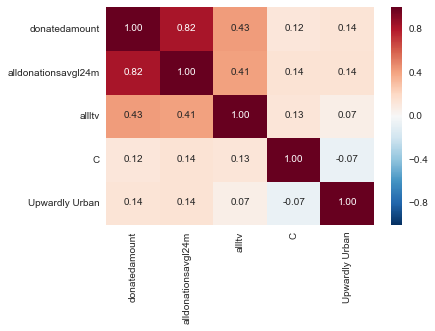

In [3]:
sns.heatmap(df.corr(), annot=True,fmt ='.2f') 

Multi-colinearity in random forest should also be avoided.

all ltv and all donations avg l24m show some correlation, but I don't think its high enough (0.41) to exclude one of the features.

In [3]:
## create test and training set - 80/20 should be ok as i am also using cross validation.
print(len(df)*0.8) 

# adding sample variable to the original dataframe, and updating with test and train.
df['sample'] ='test'
df.iloc[:148, 7:8]= 'train'

# and also separate dataframes; 
trn = df[:148] #training data 
tst = df[148:185] # test data 

df.head(1)

148.0


,donatedamount,alldonationsavgl24m,allltv,mosaicGroup,C,audienceprofile2016,Upwardly Urban,sample
0,20.0,19.0,350.0,B,0,Wealthy Wellwishers,0,train


## Stability Analysis
Mindful mums only populate bins 1 to 4 (up to £40). The second bin (£10-20) is the most common across all profiles.  Unclassified's unsual dist can be explained by the low vol of supporters (6).  WW and RR are more likely to give £100.

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


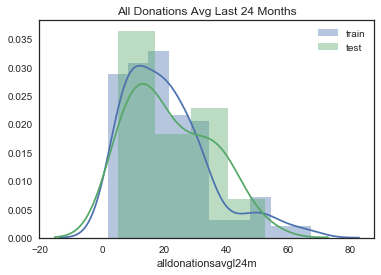

In [143]:
sns.set_style("white")
sns.distplot( trn['alldonationsavgl24m'],label='train')
sns.distplot( tst['alldonationsavgl24m'], label='test')
plt.title('All Donations Avg Last 24 Months')
plt.legend() 
plt.show()

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


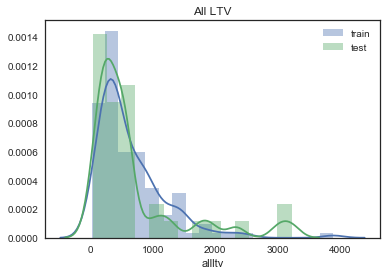

In [142]:
sns.distplot( trn['allltv'],label='train')
sns.distplot( tst['allltv'], label='test')
plt.legend() 
plt.title('All LTV')
plt.show()

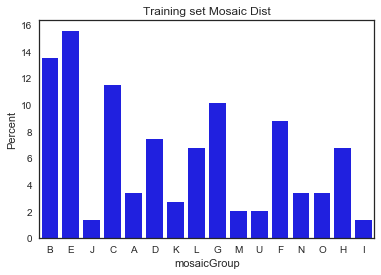

In [249]:
ax = sns.barplot(x="mosaicGroup",y='donatedamount', data=trn, 
                 color='blue',
                 estimator=lambda r: len(r)/len(trn) * 100)
ax.set(ylabel="Percent")
ax.set(title = 'Training set Mosaic Dist')
plt.show()

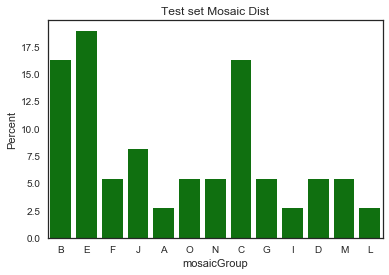

In [252]:
ax=sns.barplot(x="mosaicGroup",y='donatedamount', data=tst, 
                  color='green', 
                  estimator=lambda r: len(r)/len(tst) * 100)
ax.set(ylabel="Percent")
ax.set(title = 'Test Set Mosaic Dist')
plt.show()


Unfortunately I can't figure out how to show the training and test groups on one chart without stacking on top of each other.  
To make things either harder the mosaic groups aren't in the same order, nor are the axies fixed!! 


In [253]:
## exporting so that I can do this analysis in Tableau
df.to_csv('stability.csv', sep=',')

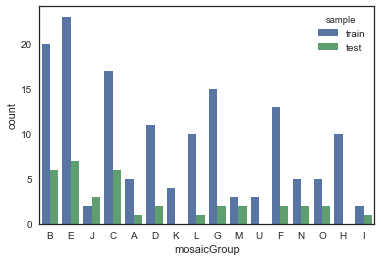

In [207]:
# Count plot below has a similar effect but only shows a count rather than the percentage, countplot doesn't allow an estimator.
sns.countplot(x="mosaicGroup", hue= 'sample', data=df)

### Creating Bins

In [4]:
##update 19.05.2017, reducing the number of bins, bins between 50 & 90 had too few observations to get good results.
# bins = np.linspace(0, 100, 11) - v1 
bins = np.linspace(0,50, 6) # v2 

def add_bins(x):
#     if np.all(x > bins[10]):
#         return 11 
#     elif np.all(x >bins[9]):
#         return 10 
#     elif np.all(x >bins[8]):
#         return 9 
#     elif np.all(x >bins[7]):
#         return 8 
#     elif np.all(x >bins[6]):
#         return 7 
    if np.all(x >bins[5]):
        return 5 
    elif np.all(x >bins[4]):
        return 4 
    elif np.all(x >bins[3]):
        return 3 
    elif np.all(x >bins[2]):
        return 2 
    elif np.all(x >bins[1]):
        return 1 
    else:
        return 0 
# add the bins to the training and test data sets   
trn['bin']  = trn['donatedamount'].map(add_bins)
tst['bin']  = tst['donatedamount'].map(add_bins)

# 5, >50 
# 4, 40.01 to 50
# 1, 0 to 10

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
trn.head()

,donatedamount,alldonationsavgl24m,allltv,mosaicGroup,C,audienceprofile2016,Upwardly Urban,sample,bin
0,20.0,19.0000,350.0,B,0,Wealthy Wellwishers,0,train,1
1,20.0,23.0000,202.0,E,0,Not in target,0,train,1
2,30.0,32.1428,961.0,J,0,Not in target,0,train,2
3,30.0,30.0000,2320.0,C,1,Rapid Responders,0,train,2
4,20.0,26.6666,816.0,C,1,Rapid Responders,0,train,1


In [5]:
# Checking the bins by calculating the average donated per bin 
print('training', pd.crosstab(trn.bin,'', values= trn.donatedamount, aggfunc='mean'))
print('test', pd.crosstab(tst.bin,'', values= tst.donatedamount, aggfunc='mean'))

training bin
0     7.510417
1    19.830986
2    27.538462
3    39.285714
4    50.000000
5    80.000000
Name: __dummy__, dtype: float64
test bin
0     7.500000
1    18.666667
2    27.500000
3    37.500000
4    50.000000
5    60.000000
Name: __dummy__, dtype: float64


audienceprofile2016
Mindful Mums            4
Not in target          56
Rapid Responders       38
Upwardly Urban         24
Wealthy Wellwishers    26
Name: __dummy__, dtype: int64

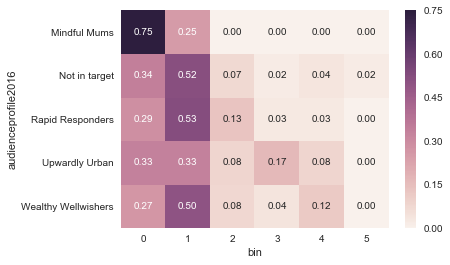

In [10]:
## this shows the distribution across the bins by audience profile.
sns.heatmap(pd.crosstab(trn.audienceprofile2016, trn.bin).apply(lambda r: r/r.sum(), axis=1),annot=True, fmt='.2f')
pd.crosstab(trn.audienceprofile2016,'')

The majority of suppporters gave the prompted £20 (bin 1).  
Mindful Mums give a max of £20 (however there are only 4 of them)  
12% of Wealthy wellwishers donate between £40 and 50 (bin 4).  
The only group to donate more than £50 is the not in target group.

### Decision Tree

Whist an advantage of Decision Trees is that they can take categorical variables as inputs, sklearn can't.  

Already created the C Mosaic dummy variable and Upwardly Urban flag which avoids this problem.

In [274]:
trn.head()

,donatedamount,alldonationsavgl24m,allltv,mosaicGroup,C,audienceprofile2016,Upwardly Urban,sample,bin
0,20.0,19.0000,350.0,B,0,Wealthy Wellwishers,0,train,1
1,20.0,23.0000,202.0,E,0,Not in target,0,train,1
2,30.0,32.1428,961.0,J,0,Not in target,0,train,2
3,30.0,30.0000,2320.0,C,1,Rapid Responders,0,train,2
4,20.0,26.6666,816.0,C,1,Rapid Responders,0,train,1


In [5]:
## v1 - using all features

from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

model = DecisionTreeClassifier(max_depth=4)#min_samples_leaf=10) # max_depth=4,max of 4 branches
y_col = 'bin' # predict either the 'donatedamount' or 'bin'

X = trn[['alldonationsavgl24m','allltv','C', 'Upwardly Urban',y_col]]
y = X[y_col]

X.drop([y_col], axis=1, inplace=True)

# Fits the model
model.fit(X, y)

##Evaluate the model using Cross Validation (builds 5 models, each on a distinct 1/5th of the data)
scores = cross_val_score(model, X,y, scoring = 'accuracy', cv=5) #using 5 folds to test accuracy of the **training** set.

print(y_col, 'CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

## nb roc_auc score returns an error when building a multiclass decition tree (auc can only be used for a binary outcome)


bin CV Accuracy [ 0.6969697   0.67741935  0.73333333  0.74074074  0.74074074], Average Accuracy 0.7178407733246444


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be les

Accuracy = overall how many right and wrong decisions were made, this is the proportion of true positives and false negatives.  
The accuracy of the decision tree is 70%, which is an improvement compared to the lapsed analysis, which had an accuracy of c.50% when predicting the donated amount bin.  

I tested min_samples_leaf which stops the tree splitting when the samples are 10 or less. The accuracy dropped marginally but remained at 70% - but each CV ranged from 63% to 83% and this volatility suggests that the model overfits in places. Unlike the max_depth 4 option where the results are consistently 70% for each CV. 

The order of the decision trees tells us the feature importance - alldonationsavgl24m is used first and several times throughout the tree, followed by allltv, Upwardly Urban is used once and C mosaic isn't used in the model.

In [72]:
##Using the **continuous/int** donatedamount as outcome
model = DecisionTreeClassifier(max_depth=3) # Max depth changed to 3 (better results)
y_col = 'donatedamount' # predict either the 'donatedamount' or 'bin'

X = trn[['alldonationsavgl24m','allltv','C', 'Upwardly Urban',y_col]]
y = np.int_(X[y_col]) # converting from float to int, otherwise it throws a "continuous" error.

X.drop([y_col], axis=1, inplace=True)

# # Fits the model
model.fit(X, y)

# ##Evaluate the model using Cross Validation (builds 5 models, each on a distinct 1/5th of the data)
scores = cross_val_score(model, X,y, scoring = 'accuracy', cv=5) #using 5 folds to test accuracy of the **training** set.
print(y_col, 'CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))


donatedamount CV Accuracy [ 0.55263158  0.6         0.67857143  0.66666667  0.6       ], Average Accuracy 0.6195739348370928


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


I reran the tree to test the continuous donated amount, but the model didn't like the float datatype.   

The accuracy drops to 60% (from 70%).  

After changing this to int the model runs fine, but you obviously lose the decimal places - but this might be a nice trade-off between trying to predict an overly precise value and trying to predict within a fairly loose £10 range - given that the prompt was £20, it's likely to result in lots of £20 donations!  


DOES THE DECISION TREE INCLUDE BOOTSTRAPPING?  
Bootstrapping is particularly helpful where you have a small sample. It randomly selects observations, builds a model, puts the observations back in the bag and then selects another random sample. This down-weights outliers as they probably won't exist in each sample and this is likely to build a model which will fit the true population better.   

A bootstrap is used for Ensemble/ Random Forest techniques, i.e. Bagging, short for Bootstrap Aggregation - this takes the average of multiple decision trees.  Therefore one decision tree doesn't use a bootstrap technique - it requires several collective trees.  

A decision tree can be evaluated using Cross Validation, however this evaluates a model after it's been fitted whilst bootstrapping is used in the construction of the model and is therefore a better tool for minimising variance.

In [42]:
## Removing C and Upwardly Urban 
y_col = 'donatedamount' # predict either the 'donatedamount' or 'bin'
X = trn[['alldonationsavgl24m','allltv',y_col]]
y = np.int_(X[y_col]) # converting from float to int, otherwise it throws a "continuous" error.
X.drop([y_col], axis=1, inplace=True)

for md in range(1, 10, 1):
    model = DecisionTreeClassifier(max_depth=md, min_samples_leaf=5) # Max depth changed to 3 (better results)
    model.fit(X, y)#Fits the model
    #Evaluate the model using Cross Validation (builds 5 models, each on a distinct 1/5th of the data)
    scores = cross_val_score(model, X,y, scoring = 'accuracy', cv=5) #using 5 folds to test accuracy of the **training** set.
    print(md,y_col, 'CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Wa

1 donatedamount CV Accuracy [ 0.44736842  0.43333333  0.60714286  0.59259259  0.6       ], Average Accuracy 0.536087440824283
2 donatedamount CV Accuracy [ 0.52631579  0.6         0.71428571  0.66666667  0.6       ], Average Accuracy 0.621453634085213
3 donatedamount CV Accuracy [ 0.52631579  0.56666667  0.71428571  0.7037037   0.6       ], Average Accuracy 0.6221943748259539
4 donatedamount CV Accuracy [ 0.52631579  0.56666667  0.60714286  0.66666667  0.6       ], Average Accuracy 0.593358395989975
5 donatedamount CV Accuracy [ 0.55263158  0.56666667  0.60714286  0.62962963  0.56      ], Average Accuracy 0.5832141464773044
6 donatedamount CV Accuracy [ 0.55263158  0.56666667  0.60714286  0.62962963  0.56      ], Average Accuracy 0.5832141464773044
7 donatedamount CV Accuracy [ 0.55263158  0.56666667  0.60714286  0.62962963  0.56      ], Average Accuracy 0.5832141464773044
8 donatedamount CV Accuracy [ 0.55263158  0.56666667  0.60714286  0.62962963  0.56      ], Average Accuracy 0.5832

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The l

In [46]:
model = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5) # Max depth changed to 3 (better results)
model.fit(X, y)#Fits the model
#Evaluate the model using Cross Validation (builds 5 models, each on a distinct 1/5th of the data)
scores = cross_val_score(model, X,y, scoring = 'accuracy', cv=5) #using 5 folds to test accuracy of the **training** set.
print(y_col, 'CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

donatedamount CV Accuracy [ 0.52631579  0.6         0.71428571  0.66666667  0.6       ], Average Accuracy 0.621453634085213


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Accuracy doesn't deteriorate when C and Upwardly Urban are removed.  
Max_depth of 3 is optimal with a minimum of 5 samples at each leaf.

** Visualising the tree **

In [47]:
# Helper function to visualize Decision Trees (creates a file tree.png)
from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree_active.dot", 'w') # output a file called tree.dot in active directory 
    export_graphviz(model,out_file = dotfile,feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree_active.dot -o tree_active.png")# this uses graphviz (not python) to create a png file.
build_tree_image(model)


The above doesn't fully work for me, it produces tree.dot but not the image.

To create the png file, run this from the command line
navigate using **cd** (change directory) to the active directory python is using (the one you're running the notebook from)

**C:\Users\BeckyC\Desktop\Data Science - GA files\Final Project>  
"C:\Program Files (x86)\Graphviz2.38\bin\dot.exe" -Tpng tree_active.dot -o tree_active.png**  
NB this uses a program called GraphViz which needs to be downloaded and installed separately.  

Below is the first run of the model, using max_depth=4 to predict the bin amount with all predictors:

<img src="Tree_active_wcomments.png">

The values at each node show the;  
- Rule being applied.  
- The gini shows the precision/purity of the split, values closer to zero show that the rule is better able to distinguish between the different outcomes.  For example if there were 100 samples, and the rule split these in half, then the gini would be 0.5, which shows an inability to split the samples in a way that gets us closer to making an accurate prediction.   
- The sample value is the  number of observations included.  
- The value array shows the actual volume per bin for the samples.  

In [10]:
# applying the prediction 
temp = trn.copy().dropna()
predictions= temp[[y_col]]
predictions = predictions.rename(index=str, columns ={y_col:'Y'})
predictions['y']= model.predict(X)
predictions.head()

,Y,y
0,20.0,20
1,20.0,20
2,30.0,20
3,30.0,20
4,20.0,20


In [48]:
# fitting model to unseen test_data 

X_test = tst.copy() # take a copy of tst 
test_pred= X_test[[y_col]]# create a new df with the true Bin.
test_pred = test_pred.rename(index=str, columns ={y_col:'Y'}) # rename the Bin column to Y (true value)
X_test.drop(['bin', 'donatedamount','audienceprofile2016','mosaicGroup','sample', 'C','Upwardly Urban'],axis=1, inplace=True)
test_pred['y']=model.predict(X_test) ##Applying the prediction 

from sklearn import metrics
print(y_col)
print ('accuracy', metrics.accuracy_score(test_pred.Y, test_pred.y) ) # proportion of correctly made preditions


donatedamount
accuracy 0.486486486486


### Confusion matrix 

correct 18
incorrect 19
total 37
Axes(0.125,0.125;0.62x0.755)


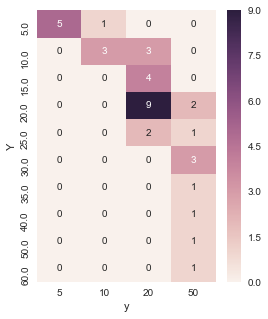

In [51]:
print('correct', test_pred[test_pred.Y== test_pred.y].count().Y) 
print ('incorrect', test_pred[test_pred.Y != test_pred.y].count().Y) 
print ('total', test_pred.count().Y) 

f,ax = plt.subplots(figsize=(4,5))
print(sns.heatmap(pd.crosstab(test_pred.Y,  #actual
                              test_pred.y) # prediction
                  ,annot= True))

# pd.crosstab(test_pred.Y,test_pred.y)

When predicting the **donationamount** (int) the decision tree is able to predict a **62%** of outcomes correctly. When tested on the unseen data, the result is similar; **48% of outcomes are correctly predicted**.  The model most struggles to predict a £20 donation which is the norm.   

**To get an unbiased donation, we need to ask for cash without a prompt**.

If I use the **bin** (categorical) which classifies donations into £10 buckets the accuracy improves to 70% (mean score from k=5 CV) and a **62% accuracy** on the unseen data.

Does an accuracy around 50%  mean that the prediction is no better than random?  
I think it is better than random because we have 11 classes we're trying to predict (or infinite in the case of the continous donated amount).  I think this means that a random model would predict 1/11th correctly (9%) - pick a number between 1 and 11, you have a 9% chance of getting it right.  Therefore 50% is a significant improvement.  

### Decision Tree feature importance  
nb the order of the tree shows the feature importance.

In [79]:
model.feature_importances_

features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort('Importance Score', inplace=True, ascending=False)

features_df.head()

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Features,Importance Score
0,alldonationsavgl24m,0.87762
1,allltv,0.12238
2,C,0.00000
3,Upwardly Urban,0.00000


Removing C and Upwardly Urban didn't change the models accuracy.

In [22]:
## Classification report (summarises precision, recall and F1 score)
from sklearn.metrics import classification_report

report = classification_report(test_pred.Y, test_pred.y)
print(report)

             precision    recall  f1-score   support

        5.0       1.00      0.83      0.91         6
       10.0       0.50      0.50      0.50         6
       15.0       0.00      0.00      0.00         4
       20.0       0.36      0.82      0.50        11
       25.0       0.00      0.00      0.00         3
       30.0       0.00      0.00      0.00         3
       35.0       0.00      0.00      0.00         1
       40.0       0.00      0.00      0.00         1
       50.0       0.00      0.00      0.00         1
       60.0       0.00      0.00      0.00         1

avg / total       0.35      0.46      0.38        37



C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 **Precision** = The models ability to not label a positive sample as negative;  true positives/ total predicted, eg/ the model correctly identified 70 donations in the bin 0, but falsey predicted 19... 70/89 = 0.79  
 
 **Recall** = The models ability to find all positive samples: true positives / total positives, eg/ 70 of a possible 102 were correctly identified as being bin 0.  
 
 **F1-score** = the weighted average of precision and recall (1 best, 0 worst). f = 2* (precision*recall)/ (precision+recall). Known as F1 because precision and recall are evenly weighted (other F scores exist).  
 
 **Support** = the number of positives (actuals) in each bin.

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


2.2972972972972974

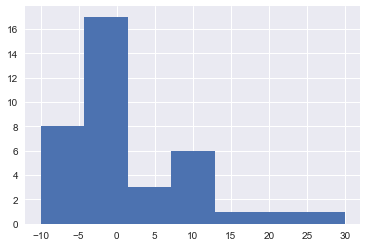

In [27]:
# actual Y minus predicted y for **donatedamount**
residuals = (test_pred.Y-test_pred.y)
plt.figure()
plt.hist(residuals, bins=np.ceil(np.sqrt(len(test_pred.y))))
(test_pred.Y -test_pred.y).mean()

<font color =green> See K047 Follow up analysis folder> model evaluation.xls for analysis on this. </font>  

Commentary based on the donatedamount(int) model  
The model doesn't predict any values between £25 and £40. 
The model mostly errors where it predicts £20 for the majority of samples (25 out of 37), and only 9 of these predictions are correct.  
The average residual (error from actual donated amount) is £2.29 - this sounds low, but because this was a fixed £20 ask, there is little variance in the donated amount and therefore the model needs to perform better.

### Random forests 

In [28]:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.cross_validation import cross_val_score

In [35]:
X = trn[['alldonationsavgl24m','allltv',y_col]]
y = np.int_(X[y_col]) # converting from float to int, otherwise it throws a "continuous" error.
X.drop([y_col], axis=1, inplace=True)

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [37]:
## Calculate optimal number of trees... 
for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees,max_depth =4) # Number of trees to build
    scores = cross_val_score(model, X, y, scoring='accuracy')
    print('n trees: {}, accuracy {}, Average accuracy {}'.format(n_trees, scores, scores.mean()))

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 1, accuracy [ 0.57142857  0.45833333  0.61363636], Average accuracy 0.5477994227994228
n trees: 11, accuracy [ 0.57142857  0.60416667  0.68181818], Average accuracy 0.6191378066378066


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 21, accuracy [ 0.60714286  0.64583333  0.63636364], Average accuracy 0.6297799422799423


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 31, accuracy [ 0.625       0.66666667  0.59090909], Average accuracy 0.6275252525252525


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 41, accuracy [ 0.60714286  0.625       0.63636364], Average accuracy 0.6228354978354979


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 51, accuracy [ 0.625       0.64583333  0.63636364], Average accuracy 0.6357323232323232


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 61, accuracy [ 0.57142857  0.66666667  0.59090909], Average accuracy 0.6096681096681097


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 71, accuracy [ 0.625       0.66666667  0.59090909], Average accuracy 0.6275252525252525


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 81, accuracy [ 0.60714286  0.64583333  0.61363636], Average accuracy 0.6222041847041847


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


n trees: 91, accuracy [ 0.625       0.66666667  0.61363636], Average accuracy 0.63510101010101


The above tells me that 51 trees returns the highest accuracy, based on predicting the donatedamount this is **63.57%**.  
It is also worth testing 91 trees as the accuracy there is 63.5% also.

### Feature importance
(pretty redundant for a model with only two features!)

In [60]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort('Importance Score', inplace=True, ascending=False)

print(features_df.head(10))
print ('y=',y_col, ', number of classes to predict: ', model.n_classes_) 
print('number of features:', model.n_features_)


              Features  Importance Score
0  alldonationsavgl24m          0.657028
1               allltv          0.342972
y= donatedamount , number of classes to predict:  14
number of features: 2


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Final model  
predictors = 'alldonationsavgl24m','allltv'  
outcome = int(donatedamount)  
trees = 90  
max_depth =4 

In [64]:
##FINAL MODEL
model = RandomForestClassifier(n_estimators = 90, # Number of trees 
                               oob_score=True,
                               max_depth = 4) # ,min_samples_leaf=5)  
model.fit(X, y)

#Cross validation
scores = cross_val_score(model, X, y,  scoring ='accuracy', cv=5)

print(y_col, 'CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))
print('oob accuracy score:', model.oob_score_)

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


donatedamount CV Accuracy [ 0.5         0.6         0.67857143  0.7037037   0.72      ], Average Accuracy 0.6404550264550265
oob accuracy score: 0.641891891892


Predicting donatedamount using 50 trees and no max_depth, results in accuracy of **64.86%** on the out of bag (oob) sample, the sample left out in the bootstrap.  The model is also cross validated by cutting up the whole sample into 5 folds and taking the average of each folds accuracy, which is 64.19%.  


### Test data 

In [75]:
Y = tst[y_col]

print(y_col)
print ('accuracy', metrics.accuracy_score(Y, model.predict(X_test)) ) # proportion of correctly made preditions
# predictions[predictions.Y== predictions.y]


donatedamount
accuracy 0.567567567568


The accuracy drops  on the test set to 56.7% vs the training set 64%.  

37


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


1.8918918918918919

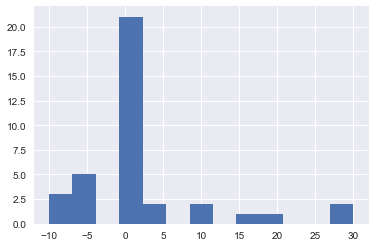

In [77]:
# actual Y minus predicted y for **donatedamount**
residuals = (Y -model.predict(X_test))
plt.figure()
plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
print(len(X_test))

(Y -model.predict(X_test)).mean()

The residual graph shows that the majority of predictions are correct (zero residual)  

The model is more likely to overpredict, as shown by the negative residuals.

The mean residual error on the donatedamount model is £1.89, which is an improvement compared to the individual decision tree, which was £2.29.

### Overall (test & training data)

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


pred           1   2   5   10  20  30  40  50
donatedamount                                
1.0             1   0   0   0   0   0   0   0
2.0             0   1   0   0   0   0   0   0
2.5             0   1   0   0   0   0   0   0
5.0             0   0  22   3   0   0   0   0
10.0            0   0   4  17  11   0   0   0
13.0            0   0   0   0   1   0   0   0
15.0            0   0   0   0   5   0   0   0
20.0            0   0   0   1  79   0   0   0
23.0            0   0   0   0   1   0   0   0
25.0            0   0   0   0   7   1   0   0
30.0            0   0   0   0   6   4   0   0
35.0            0   0   0   0   2   0   0   0
40.0            0   0   0   0   4   0   2   1
50.0            0   0   0   0   2   0   0   7
60.0            0   0   0   0   0   1   0   0
80.0            0   0   0   0   1   0   0   0


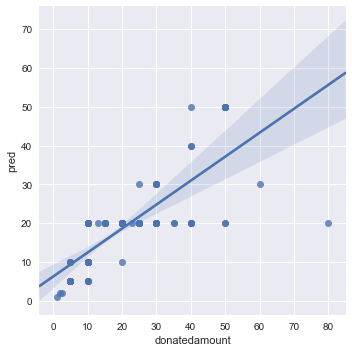

In [91]:
#because volumes are so low in this analysis I'm using the entire file to evaluate, which includes the unseen and seen data.
Xtotal = df[['alldonationsavgl24m','allltv']]
predictions = df[['donatedamount']]
predictions['pred']  = model.predict(Xtotal)
predictions.head()

sns.lmplot( 'donatedamount','pred', predictions)
print(pd.crosstab(predictions.donatedamount, predictions.pred)) 


In [94]:
report = classification_report(predictions['donatedamount'].astype(int), predictions.pred)
print(report)

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         1
          2       1.00      1.00      1.00         2
          5       0.85      0.88      0.86        25
         10       0.81      0.53      0.64        32
         13       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         5
         20       0.66      0.99      0.79        80
         23       0.00      0.00      0.00         1
         25       0.00      0.00      0.00         8
         30       0.67      0.40      0.50        10
         35       0.00      0.00      0.00         2
         40       1.00      0.29      0.44         7
         50       0.88      0.78      0.82         9
         60       0.00      0.00      0.00         1
         80       0.00      0.00      0.00         1

avg / total       0.67      0.72      0.67       185



C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([  22.,  134.,   12.,    7.,    2.,    4.,    3.,    0.,    0.,
           0.,    0.,    1.]),
 array([-10.        ,  -4.16666667,   1.66666667,   7.5       ,
         13.33333333,  19.16666667,  25.        ,  30.83333333,
         36.66666667,  42.5       ,  48.33333333,  54.16666667,  60.        ]),
 <a list of 12 Patch objects>)

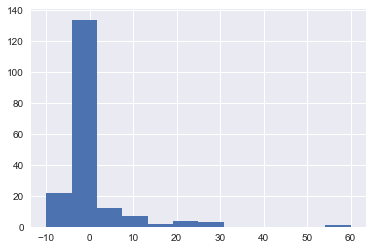

In [99]:
# actual Y minus predicted y for **donatedamount**
residuals = (predictions.donatedamount -predictions.pred)
plt.figure()
plt.hist(residuals, bins=12) #np.ceil(np.sqrt(len(y))))

# (Y -model.predict(X_test)).mean()

## Summary 
The overall accuracy seems quite operational, with an f1-score of 67%.   

The recall averages at 72%, but there is some volatility across the donation amounts.  Recall tells us how many predictions we missed (false negatives), that is those that were predicted false, for example, not predicted £20 but actually were £20. In a fraud scenario, these are fraudulent transactions not detected.  In the table below it shows the stats for the £20 subset, we correctly predicted £20 for 79 of the 80 £20 donations and therefore missed very few.

Precision measures the distribution of predictions, so for all of the positive predictions, how many of them actually turned out to be correct.  In a fraud scenario, this is how cleanly did we identify fraud without capturing any genuine (false positives).  In the £20 subset below, when we predicted £20 the model was right 66% of the time, and therefore 33% of false positives.  The overall precision of the model is quite high (all values >=0.66) and averages at 67%.  


||Actual||||  
|---|---|---|---|---|---|
|**Predicted**|£20|Other|||
|£20|79|40|66%|<< precision|
|Other|1|65|||
|recall >>|99%||78%|<<accuracy


Where both precision and recall is zero, the model hasn't made any predictions for this amount.  

** In this context there isn't an argument for favouring a higher precision over recall or vice versa.  A missed or falsely classified prediction is still inaccurate, and it doesn't change our decision to ask for cash **. Therefore, overall accuracy is the best measure alongside the residual graph to show how well centred values are around zero - and whether there is a disposition to over or under prompt and the risk associated with either.  

The purpose of this analysis was to understand if de-personalising the prompt value would identify relationships with other features in the data.  The result in this sense is quite poor, as none of the supporters characteristics (mosaic, gender etc) were significant enough to be a feature.  The most powerful predictors were those relating to the supporters previous giving.  

What also became apparent is that there is a strong correlation between the prompted amount and the donated amount, and whilst we have "normalised" the prompt it is still strongly influencing the supporters behaviour.  To remove any bias it would be sensible to ask for cash without any prompt - is this an option?  

Alternatively, we could analyse response to all personalised prompts, on the basis that each has a consistently applied bias, and the prompt strategy is derived from previous giving.  So overlaying mosaic, for instance, could still identify a valid relationship?

What are my recommendations?  
Increase fixed prompt to £25 to test sensitivity or remain at £20 to grow the sample base?  
See if a sample of variable prompted supporters can help us understand the relationship with mosaic (any other categorical variables?)  
See if we can run a "no prompt" test? This will enable us to build a model from unbiased data. But the model is predicting donation amount and the relationship between prompted amount and donated amount would still need to be understood.